In [2]:
import os
import sys

# find root directory and add to path
root_index = os.getcwd().rfind('tutorials')
sys.path.append(os.path.dirname(os.getcwd()[:root_index]))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn

%load_ext autoreload
%autoreload 2


def simulate_motion(plant, excitation_pattern, movement_duration):
    j_state, _, m_state, g_state = plant.get_initial_state(joint_state=tf.zeros((1, 4)))
    j = j_state
    m = m_state
    g = g_state

    t_fn = np.arange(0., movement_duration, plant.dt)
    excitation = tf.ones((1, plant.n_muscles)) * excitation_pattern

    for _ in range(len(t_fn)):
        j, c, m, g = plant(excitation, j, m, g)
        j_state = tf.concat([j_state, j], axis=0)
        m_state = tf.concat([m_state, m], axis=0)
        g_state = tf.concat([g_state, g], axis=0)

    return j_state, m_state, g_state


def plot_motion(j_state, g_state, plant, movement_duration):
    t_fn = np.arange(0., movement_duration + plant.dt, plant.dt)

    plt.subplot(131)
    plt.plot(t_fn, j_state[:, 0], label='x')
    plt.plot(t_fn, j_state[:, 1], label='y', linestyle=':', linewidth=3)
    plt.ylabel('position (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(132)
    plt.plot(t_fn, g_state[:, 0, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, g_state[:, 0, 1], label=plant.muscle_name[1])
    plt.plot(t_fn, g_state[:, 0, 2], label=plant.muscle_name[2], linestyle=':', linewidth=3)
    plt.plot(t_fn, g_state[:, 0, 3], label=plant.muscle_name[3])
    plt.ylabel('musculotendon length (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(133)
    plt.plot(t_fn, g_state[:, 1, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, g_state[:, 1, 1], label=plant.muscle_name[1])
    plt.plot(t_fn, g_state[:, 1, 2], label=plant.muscle_name[2], linestyle='--')
    plt.plot(t_fn, g_state[:, 1, 3], label=plant.muscle_name[3], linestyle=':')
    plt.ylabel('musculotendon velocity (m/sec)')
    plt.xlabel('time (sec)')
    plt.legend()


def print_muscle_states(plant, states):
    state_idx = 0

    for m in range(plant.n_muscles):
        muscle = plant.muscle
        muscle_name = plant.muscle_name[m]
        print('\ninitial ' + muscle_name + ' state:\n')
        state_m = states[:, state_idx:state_idx + plant.muscle_state_dim]
        state_idx += plant.muscle_state_dim

        for j in range(plant.muscle_state_dim):
            state_name = muscle.state_name[j]
            print(state_name + ' = ' + str(states[:, j, m].numpy()))


def plot_muscle_states(plant, states, movement_duration):
    n_muscle_states = plant.muscle_state_dim
    t_plot = np.arange(0., movement_duration + plant.dt, plant.dt)
    for j in range(n_muscle_states):
        plt.subplot(3, 4, j+1)
        plt.plot(t_plot, states[:, j, 0], label=plant.muscle_name[0])
        plt.plot(t_plot, states[:, j, 1], label=plant.muscle_name[1], linestyle=':', linewidth=3.)
        plt.title(plant.muscle.state_name[j])
        plt.xlabel('time (sec)')
    plt.legend()


print('All packages imported.')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All packages imported.


# I. Intro
In this notebook, we will build a 2D point-mass system for each muscle type and see how each muscle type behave to ensure they work properly. The point-mass will be tied to 4 muscles forming a X shaped, as illustrated below.

<img src="img/pointmass.png" alt="drawing" width="300"/>

The 2D point-mass is the simplest skeleton possible, making it a good toy model to assess how each muscle class works. It is recommended to check the ```build-plant.ipynb``` notebook for a more detailed explanation on how to build a full plant.

# II. ReLu muscles

Each muscles is a simple one-segment muscle so we have two fixation points (start and end). The last fixation point is the same for all four muscles since they all contact the same point-mass at its center, but their first fixation point is different because they link to different points on the worldspace.

For the fourth muscle, we will use three fixation points, with the first two linked to the worldspace. In effect this should not change the moment arms, but it should increase muscle lengths. This will allow us to test if the plant geometry is working properly.

In [3]:


# create the point-mass and associated muscles
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.ReluMuscle()
relu_plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type)


# PointMass skeletons only have one "bone", which is the point itself.
relu_plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[2, 2], [0, 0]], name='UpRight', max_isometric_force=500)
relu_plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, 2], [0, 0]], name='UpLeft', max_isometric_force=500)
relu_plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, -2], [0, 0]], name='DownLeft', max_isometric_force=500)

# Three-points muscle
relu_plant.add_muscle(path_fixation_body=[0, 0, 1], path_coordinates=[[4, -2], [2, -2], [0, 0]], name='DownRight', max_isometric_force=500)

print('Plant model created.')


Plant model created.


## II. 1. Inspecting initial muscle states

Muscle states should have a shape of ```(batch_size, n_features, n_muscles)```. The (ordered) list of features is always available in the ```Muscle.state_name``` attribute.

First let's try random starting positions (the default when you use `plant.get_initial_state`). All values should be 0, except for the muscle lenght, which should vary randomly depending on the (randomly drawn) starting position.

In [4]:

states = relu_plant.get_initial_state(batch_size=2)
# joint_state, cartesian_state, muscle_state, geometry_state = states
_, _, muscle_state, _ = states
print('Features for a ReLu muscle:\n' + str(relu_plant.muscle.state_name) + '\n\n')
print('initial muscle state:\n' + str(muscle_state) + '\n')


Features for a ReLu muscle:
['excitation/activation', 'muscle length', 'muscle velocity', 'force']


initial muscle state:
tf.Tensor(
[[[0.        0.        0.        0.       ]
  [3.7358372 3.1028736 1.9286845 4.8369837]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]

 [[0.        0.        0.        0.       ]
  [3.3587582 2.374677  2.3903413 5.369851 ]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]], shape=(2, 4, 4), dtype=float32)



Now let us try when we manually enforce a starting position at the center of the workspace (`[x, y] = [0, 0]`).
The muscle length should be identical for all batches and all muscles.


In [5]:

states = relu_plant.get_initial_state(joint_state=tf.zeros((3, 4)))
print('initial muscle state:\n' + str(states[2]) + '\n')


initial muscle state:
tf.Tensor(
[[[0.        0.        0.        0.       ]
  [2.828427  2.828427  2.828427  4.8284273]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]

 [[0.        0.        0.        0.       ]
  [2.828427  2.828427  2.828427  4.8284273]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]

 [[0.        0.        0.        0.       ]
  [2.828427  2.828427  2.828427  4.8284273]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]], shape=(3, 4, 4), dtype=float32)



## II. 2. Simulating motion

In the 1st simulation run we excite only the muscle pulling to the up-right corner. Let's do a half-second movement.

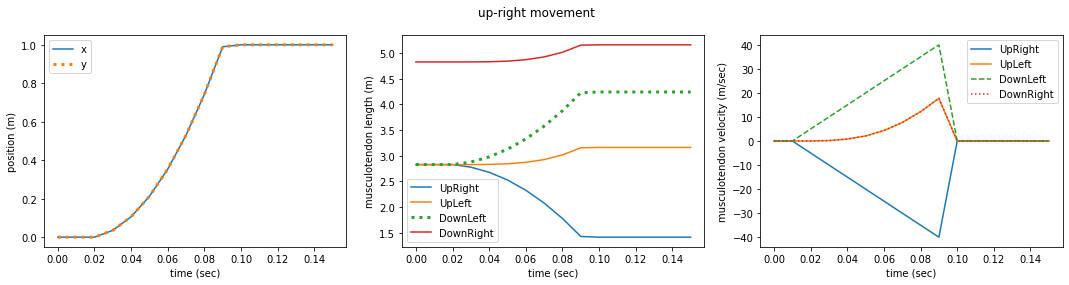

In [6]:
# up-right movement
#--------------------------------

t_end = 0.15
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, _, geometry_state = simulate_motion(relu_plant, [1, 0, 0, 0], t_end)
plot_motion(joint_state, geometry_state, relu_plant, t_end)
plt.suptitle('up-right movement')
plt.show()


In the 2nd simulation run we excite the muscles pulling to the right and down simultaneously.
When the final position (down-right
corner) is reached, the down and right muscles should have the same length as in the start, and the up and left muscles
should have more than twice the legnth they had at the start.

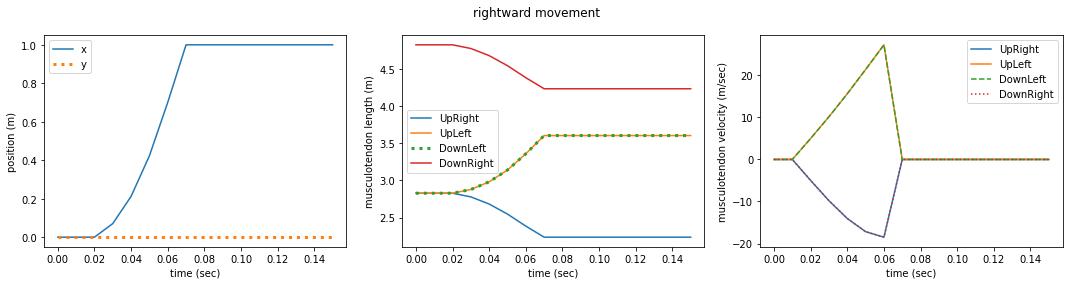

In [7]:
# rightward movement
#--------------------------------

t_end = 0.15
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, _, geometry_state = simulate_motion(relu_plant, [1, 0, 0, 1], t_end)
plot_motion(joint_state, geometry_state, relu_plant, t_end)
plt.suptitle('rightward movement')
plt.show()


In the 3rd simulation run we excite all four muscles at the same time, for an isometric co-contraction. None of the
path lengths should change.

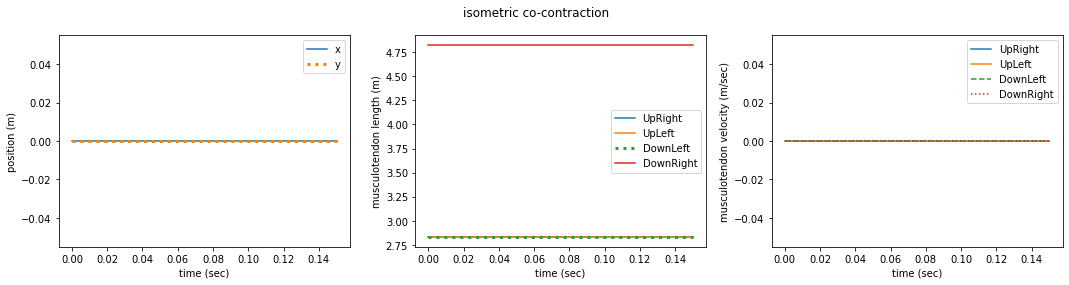

In [8]:
# Isometric co-contraction
#--------------------------------

t_end = 0.15
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, _, geometry_state = simulate_motion(relu_plant, [1, 1, 1, 1], t_end)
plot_motion(joint_state, geometry_state, relu_plant, t_end)
plt.suptitle('isometric co-contraction')
plt.show()


# III. Hill muscles (Kistemaker version)

The first Hill muscle type we look at is the implementation from [Kistemaker et al., 2006](https://www.physiology.org/doi/10.1152/jn.00983.2005) and [Kistemaker et al., 2010](https://www.physiology.org/doi/10.1152/jn.00483.2010).

## III. 1. Muscle states

Let's look at the variables included in the muscle state. To do so, we first build the plant and create a dummy muscle.

In [9]:

skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[1,1], [0,0]],
    max_isometric_force=1,
    tendon_length=0.,
    optimal_muscle_length=0.4)
muscle = plant.muscle


print('Features for a ReLu muscle:\n' + str(muscle.state_name) + '\n\n')


Features for a ReLu muscle:
['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']





## III. 2. Muscle force curves

Next, let's assess what the force production curves look like. Hill-type muscles consist of an active and passive length-force relationship.

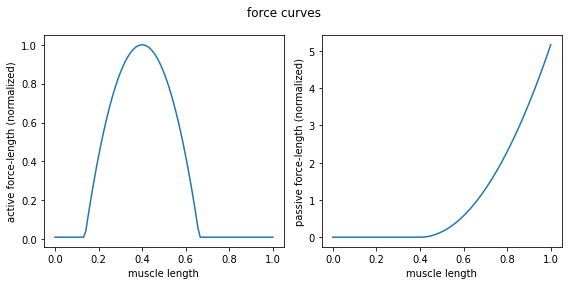

In [10]:



n_points = 100

m = tf.zeros((n_points, plant.muscle_state_dim, plant.n_muscles))
deriv = muscle.update_ode(excitation=0., muscle_state=m)

# Each batch entry contains a different musculotendon length.
# Since the tendon length is set to 0, the musculotendon length is the same as
#  the muscle length in this particular example.
muscle_len = np.linspace(0.,1., n_points).reshape((-1,1,1))
zeros = np.zeros((n_points, plant.geometry_state_dim-1, plant.n_muscles))
g =  tf.convert_to_tensor(np.concatenate([muscle_len, zeros], axis=1))

states = muscle.integrate(dt=plant.dt, state_derivative=deriv, muscle_state=m, geometry_state=g)


plt.figure(figsize=(8, 4)).set_tight_layout(True)
plt.suptitle('force curves')
x = muscle_len.reshape(-1,1)

plt.subplot(121)
plt.plot(x, states[:, 4, :])
plt.xlabel('muscle length')
plt.ylabel('active force-length (normalized)')

plt.subplot(122)
plt.plot(x, states[:, 3, :])
plt.xlabel('muscle length')
plt.ylabel('passive force-length (normalized)')

plt.show()


## III. 3. Inspecting initial states

First, let's try random starting positions (the default when you use `plant.get_initial_state`).


In [11]:
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.001)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpLeft')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownLeft')


states = plant.get_initial_state(batch_size=4)
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [2.6677809 2.8510551 2.6917017 3.6359644]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.0000000e+00 1.4693226e-04 0.0000000e+00 1.8713172e-01]
force-length CE = [0.9925943  0.999853   0.9946356  0.81286824]
force-velocity CE = [0.00099259 0.00099985 0.00099464 0.00081287]
force = [0.04962973 0.05733926 0.04973178 9.397229  ]

initial UpLeft state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [3.4292433 2.8601108 3.3690956 3.549848 ]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.10358707 0.00028807 0.083885   0.14934814]
force-length CE = [0.89641297 0.9997118  0.9161151  0.85065204]
force-velocity CE = [0.00089641 0.00099971 0.00091612 0.00085065]
force = [5.2241745  0.06438895 4.2400556  7.509939  ]

initial DownRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [2.2467043 2.7969215 2.3010457 2.3124545]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0. 0. 0. 0

Now let us try when the point mass starts in the center of the workspace (`[x, y] = [0, 0]`).

In [12]:


states = plant.get_initial_state(joint_state=tf.zeros((3, 2)))
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [0.001 0.001 0.001]
force = [0.05 0.05 0.05]

initial UpLeft state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [0.001 0.001 0.001]
force = [0.05 0.05 0.05]

initial DownRight state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [0.001 0.001 0.001]
force = [0.05 0.05 0.05]

initial DownLeft state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [0.001 0.001 0.001]
for

## III. 4. Simulating motion
In the 1st simulation run, we excite only the muscle pulling to the upper right corner.

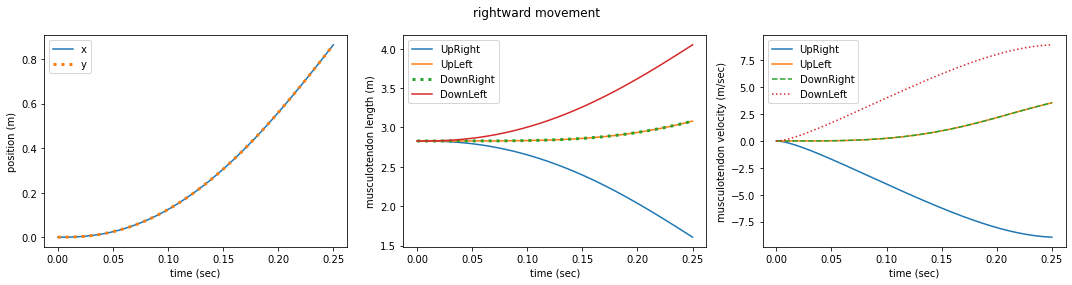

In [13]:

t_end = 0.25
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 0., 0., 0.], t_end)
plot_motion(joint_state, geometry_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()


We can observe the states changing over time below. Only the upper right and upper left muscles are plotted for the sake of simplicity.


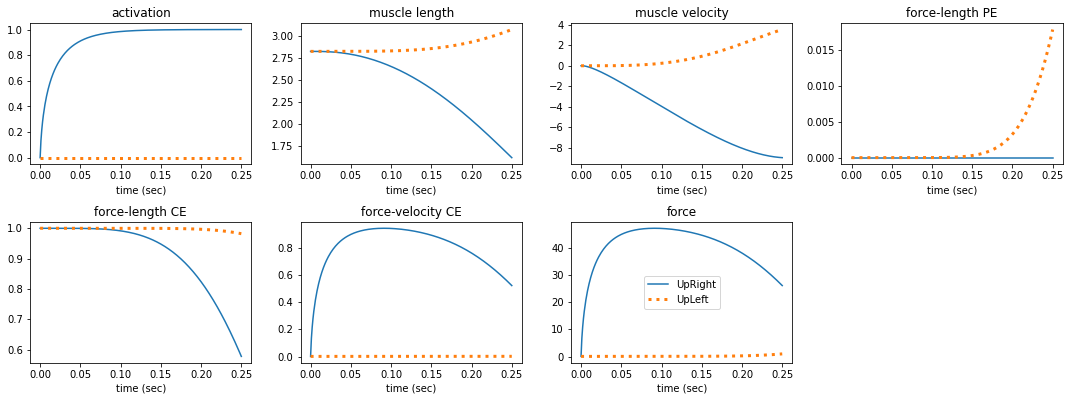

In [14]:


plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)


In the second simulation run we excite all four muscles at the same time, for an isometric co-contraction. Here none of the
path lengths should change.

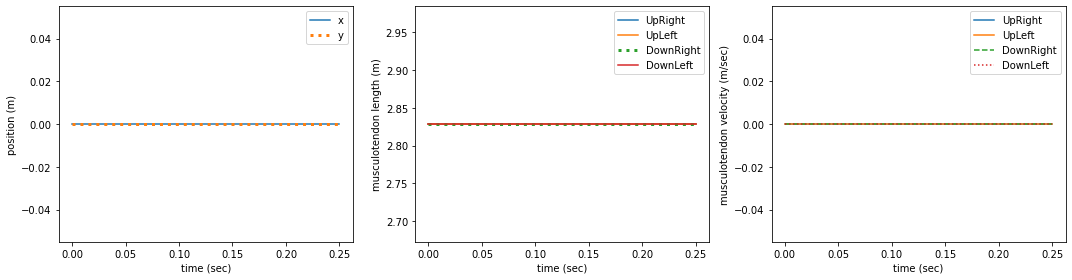

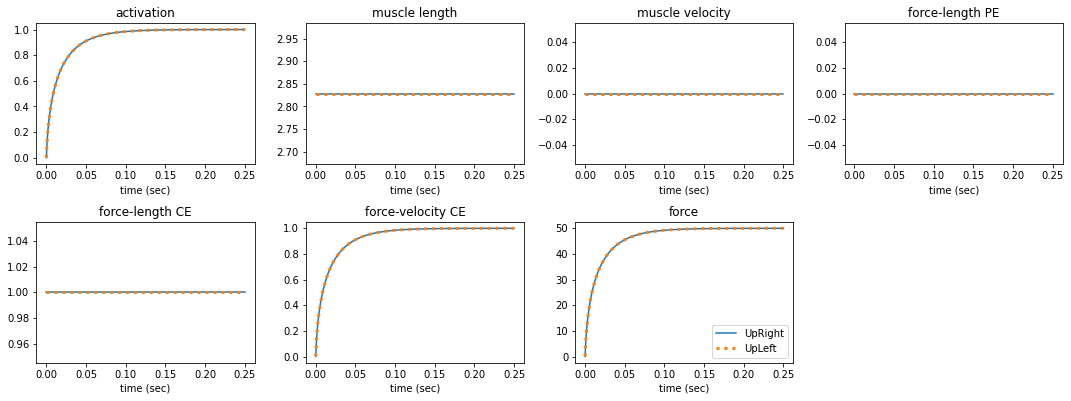

In [15]:
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 1., 1., 1.], t_end)

plt.figure(figsize=(15, 4)).set_tight_layout(True)
plot_motion(joint_state, geometry_state, plant, t_end)

plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)

# IV. Hill muscles (Thelen version)

The Thelen version of a Hill-type muscle is detailed in [Thelen et al., 2003](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Thelen+2003+Muscle+Model).

## IV. 1. Muscle states

In [16]:
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscleThelen()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[1,1], [0,0]],
    max_isometric_force=1,
    tendon_length=0.,
    optimal_muscle_length=0.4)
muscle = plant.muscle


print('Features for a Thelen Hill  muscle:\n' + str(muscle.state_name) + '\n\n')

Features for a Thelen Hill  muscle:
['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']




## IV. 2.Muscle force curves

Two key differences can be observed compared to the *Kistemaker* Hill-type muscle.
- The force-length curve does not reach 0 in the Thelen muscle.
- Passive forces increase much faster in the Thelen muscle, as its formulation is an exponential function instead of a quadriatic function.


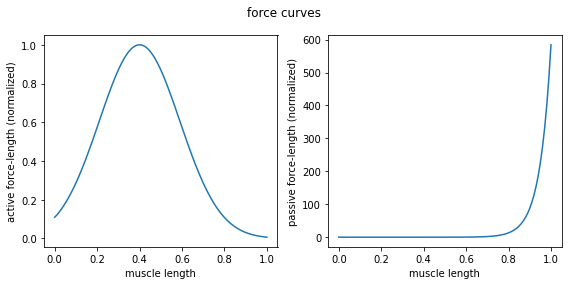

In [17]:


n_points = 100

m = tf.zeros((n_points, plant.muscle_state_dim, plant.n_muscles))
deriv = muscle.update_ode(excitation=0., muscle_state=m)

# Each batch entry contains a different musculotendon length.
# Since the tendon length is set to 0, the musculotendon length is the same as
#  the muscle length in this particular example.
muscle_len = np.linspace(0.,1., n_points).reshape((-1,1,1))
zeros = np.zeros((n_points, plant.geometry_state_dim-1, plant.n_muscles))
g =  tf.convert_to_tensor(np.concatenate([muscle_len, zeros], axis=1))

states = muscle.integrate(dt=plant.dt, state_derivative=deriv, muscle_state=m, geometry_state=g)


plt.figure(figsize=(8, 4)).set_tight_layout(True)
plt.suptitle('force curves')
x = muscle_len.reshape(-1,1)

plt.subplot(121)
plt.plot(x, states[:, 4, :])
plt.xlabel('muscle length')
plt.ylabel('active force-length (normalized)')

plt.subplot(122)
plt.plot(x, states[:, 3, :])
plt.xlabel('muscle length')
plt.ylabel('passive force-length (normalized)')

plt.show()

## IV. 3. Inspecting initial states

Similar to the Kistemaker Hill muscle, let us first look at random initial states.

In [18]:
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscleThelen()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.001)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpLeft')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownLeft')


states = plant.get_initial_state(batch_size=4)
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [2.262868  2.9248374 2.6953733 2.529813 ]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.        0.0019987 0.        0.       ]
force-length CE = [0.9149836  0.9974214  0.99509454 0.9755347 ]
force-velocity CE = [1. 1. 1. 1.]
force = [0.04574918 0.14980613 0.04975473 0.04877673]

initial UpLeft state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [3.3848543 2.0144165 2.2769802 2.2072697]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.02332673 0.         0.         0.        ]
force-length CE = [0.91759133 0.8318865  0.9189988  0.89836687]
force-velocity CE = [1. 1. 1. 1.]
force = [1.212216   0.04159432 0.04594994 0.04491835]

initial DownRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [2.4109156 3.6425793 3.3933873 3.5045946]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.         0.05326588 0.02402283 0.03471191]
force-length CE = [0.95273256 0.8318332  0.91

Now let us try when the point mass starts in the center of the workspace (`[x, y] = [0, 0]`).

In [19]:
states = plant.get_initial_state(joint_state=tf.zeros((3, 2)))
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]

initial UpLeft state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]

initial DownRight state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]

initial DownLeft state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]


## IV. 4. Simulating motion
In the 1st simulation run, we excite only the muscle pulling to the upper right corner.


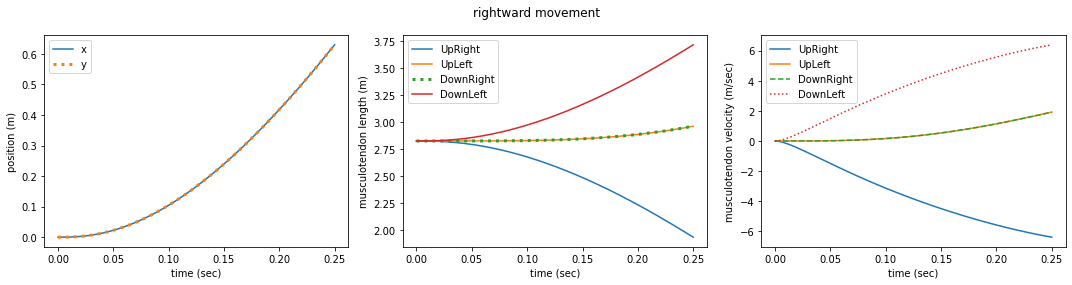

In [20]:
t_end = 0.25
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 0., 0., 0.], t_end)
plot_motion(joint_state, geometry_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()

We can observe the states changing over time below. Only the upper right and upper left muscles are plotted for the sake of simplicity.

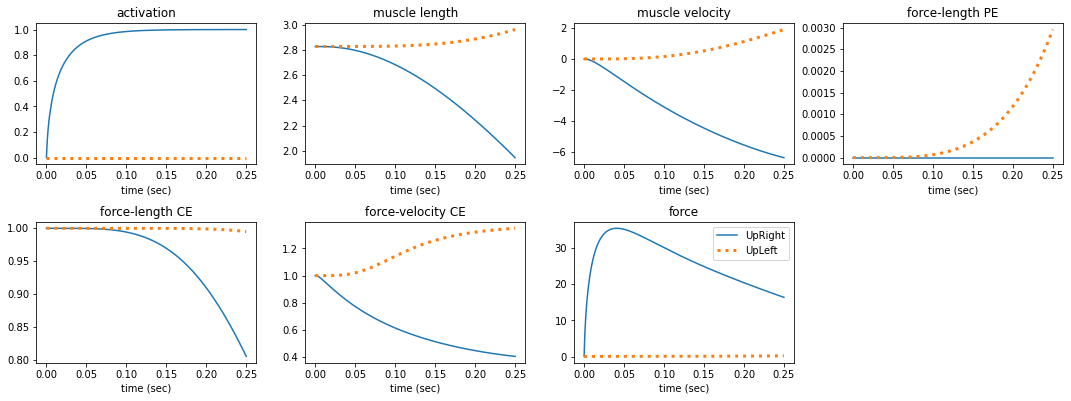

In [21]:

plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)


And finally, we simulate an isometric co-contraction of all muscles in the system.
Note that some variables are at floating point precision.

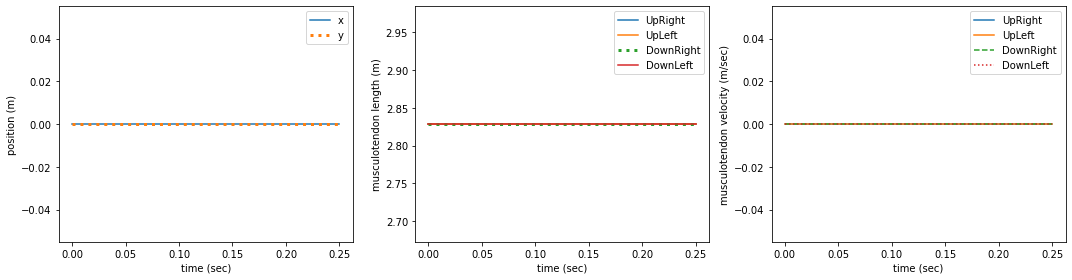

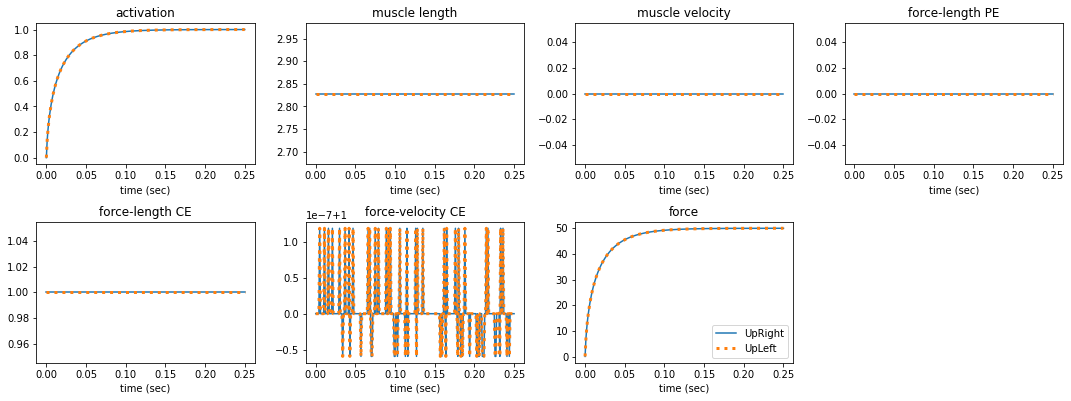

In [22]:
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 1., 1., 1.], t_end)

plt.figure(figsize=(15, 4)).set_tight_layout(True)
plot_motion(joint_state, geometry_state, plant, t_end)

plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)

# V. Compliant tendon Hill-type muscle

The `CompliantTendonHillMuscle` class is an extention of the `RigidTendonHillMuscle` class to inclde a compliant tendon. In fact, the muscle model proposed in [Kistemaker et al., 2006](https://www.physiology.org/doi/10.1152/jn.00983.2005) and [Kistemaker et al., 2010](https://www.physiology.org/doi/10.1152/jn.00483.2010) includes a compliant tendon, and the `RigidTendonHillMuscle` class is a modified version of the original model formulation. Similarly, the `RigidTendonHillMuscleThelen` class is a modified version from the original, compliant-tendon version.

## V. 1. Muscle states
Let us first look at the state features.


In [23]:

skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.CompliantTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.0001)


# we make the tendon very long to reduce its stiffness
# and allow looking at the force production curves in more details
plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[6,0], [0,0]],
    max_isometric_force=1,
    tendon_length=5,
    optimal_muscle_length=0.8)
muscle = plant.muscle


print('Features for a compliant tendon muscle:\n' + str(muscle.state_name) + '\n\n')


Features for a compliant tendon muscle:
['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length SE', 'active force', 'force']





## V. 2. Muscle force curves
Compliant tendon muscles do not compute force-length curves directly. Rather, they make use of tendon forces and assume equilibrium between tendon and muscle forces to obtain output forces for a given muscle. Below we look at the tendon, muscle passive and active forces as a function of muscle length.

Note that the tendon is much stiffer than the passive muscle forces. Additionally, the tendon forces are capped at 1 to prevent the muscle from outputing more than its maximum isometric force. Finally, note how the active force reaches 0 faster than the tendon force, due to the overlap between tendon and passive forces leading to them cancelling each other in that region.


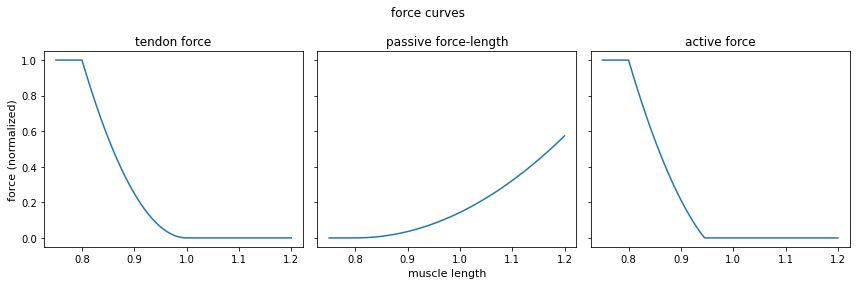

In [24]:

n_points = 100

# create muscle state
m = np.zeros((n_points, plant.muscle_state_dim, plant.n_muscles))
muscle_len = np.linspace(0.75, 1.2, n_points).reshape(-1, 1)
m[:, 1, :] = muscle_len
deriv = muscle.update_ode(excitation=0., muscle_state=m)

# create geometry state
zeros = np.zeros((n_points, plant.geometry_state_dim, plant.n_muscles))
zeros[:, 0, 0] = 6  # the musculotendon length is 6 m due to the way it was built above.
g = tf.convert_to_tensor(zeros)

states = muscle.integrate(dt=plant.dt, state_derivative=deriv, muscle_state=m, geometry_state=g)

#-----------
# plot
#-----------
fig, axs = plt.subplots(1, 3, sharey='all', sharex='all')
fig.set_tight_layout(True)
fig.set_size_inches(12, 4)
fig.suptitle('force curves')

x = muscle_len.reshape(-1,1)

axs[0].plot(x, states[:, 4, :])
axs[0].set_title('tendon force')
axs[0].set_ylabel('force (normalized)', fontsize=11)

axs[1].plot(x, states[:, 3, :])
axs[1].set_xlabel('muscle length', fontsize=11)
axs[1].set_title('passive force-length')

axs[2].plot(x, states[:, 5, :])
axs[2].set_title('active force')

plt.show()


## V. 3. Inspecting initial states

Let's use the pre-built `CompliantTendonArm26` plant object.


In [25]:

plant = mn.plants.CompliantTendonArm26()
states = plant.get_initial_state(batch_size=4)
print_muscle_states(plant, states[2])



initial pectoralis state:

activation = [0.01 0.01 0.01 0.01]
muscle length = [0.09707291 0.14477389 0.09912601 0.14702442]
muscle velocity = [-0.18640545 -0.22575001 -0.19066    -0.22570212]
force-length PE = [0.         0.01485293 0.         0.02170308]
force-length SE = [0.         0.014853   0.         0.02170375]
active force = [0.0000000e+00 6.7055225e-08 0.0000000e+00 6.7055225e-07]
force = [ 0.       12.446812  0.       18.187742]

initial deltoid state:

activation = [0.01 0.01 0.01 0.01]
muscle length = [0.17990911 0.13307567 0.17791636 0.13075387]
muscle velocity = [-0.23555346 -0.23454097 -0.23586378 -0.2335044 ]
force-length PE = [0.18659613 0.         0.16842915 0.        ]
force-length SE = [0.18659924 0.         0.16842538 0.        ]
active force = [3.1143427e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00]
force = [225.22528   0.      203.28943   0.     ]

initial brachioradialis state:

activation = [0.01 0.01 0.01 0.01]
muscle length = [0.10589143 0.10068922 0.083317

And with fixed starting positions:

In [26]:
states = plant.get_initial_state(joint_state=(np.pi/4) * tf.ones((3, 2)))
print_muscle_states(plant, states[2])


initial pectoralis state:

activation = [0.01 0.01 0.01]
muscle length = [0.1355095 0.1355095 0.1355095]
muscle velocity = [-0.22575533 -0.22575533 -0.22575533]
force-length PE = [0.00029307 0.00029307 0.00029307]
force-length SE = [0.00029283 0.00029283 0.00029283]
active force = [0. 0. 0.]
force = [0.24539474 0.24539474 0.24539474]

initial deltoid state:

activation = [0.01 0.01 0.01]
muscle length = [0.14255574 0.14255574 0.14255574]
muscle velocity = [-0.23585105 -0.23585105 -0.23585105]
force-length PE = [0.00076788 0.00076788 0.00076788]
force-length SE = [0.00076804 0.00076804 0.00076804]
active force = [1.5646219e-07 1.5646219e-07 1.5646219e-07]
force = [0.927022 0.927022 0.927022]

initial brachioradialis state:

activation = [0.01 0.01 0.01]
muscle length = [0.09957521 0.09957521 0.09957521]
muscle velocity = [-0.15499091 -0.15499091 -0.15499091]
force-length PE = [0.01557695 0.01557695 0.01557695]
force-length SE = [0.01557705 0.01557705 0.01557705]
active force = [9.77888


## V. 4. Simulating motion
In the 1st simulation run, we create a tug-of-war plant and excite the muscle pulling to the right.

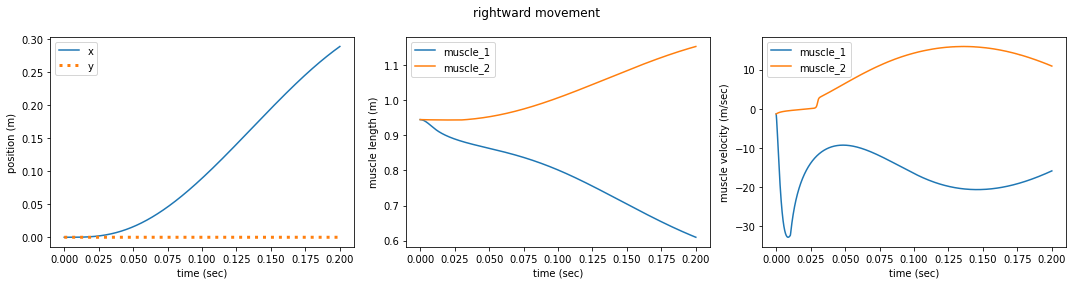

In [27]:


skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.CompliantTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.0001, integration_method='rk4')

# we create a tug-of-war plant
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[6,0], [0,0]],
                 max_isometric_force=100, tendon_length=5, optimal_muscle_length=0.8)

plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-6,0], [0,0]],
                 max_isometric_force=100, tendon_length=5, optimal_muscle_length=0.8)


# custom plotting function
def plot_tow(j_state, m_state, plant, movement_duration):
    t_fn = np.arange(0., movement_duration + plant.dt, plant.dt)

    plt.subplot(131)
    plt.plot(t_fn, j_state[:, 0], label='x')
    plt.plot(t_fn, j_state[:, 1], label='y', linestyle=':', linewidth=3)
    plt.ylabel('position (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(132)
    plt.plot(t_fn, m_state[:, 1, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, m_state[:, 1, 1], label=plant.muscle_name[1])
    plt.ylabel('muscle length (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(133)
    plt.plot(t_fn, m_state[:, 2, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, m_state[:, 2, 1], label=plant.muscle_name[1])
    plt.ylabel('muscle velocity (m/sec)')
    plt.xlabel('time (sec)')
    plt.legend()



t_end = 0.2
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, _ = simulate_motion(plant, [0.5, 0.], t_end)
plot_tow(joint_state, muscle_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()


And finally, we create an isometric co-contraction. Muscle lengths and velocities vary over time, while position does not move. This indicates that the musculotendon complex tenses up in an isometric fashion.

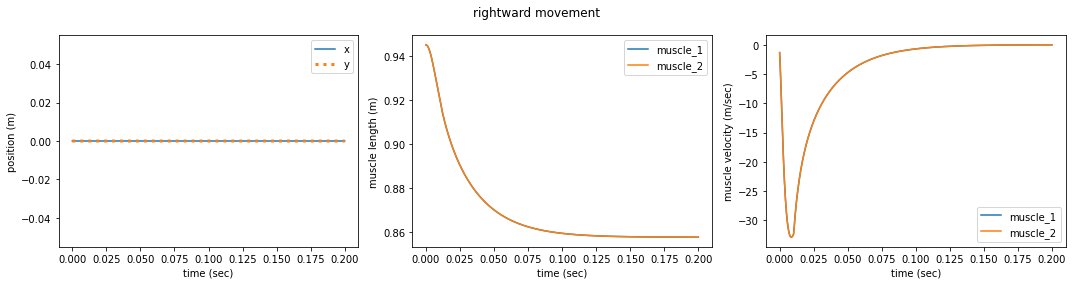

In [28]:

t_end = 0.2
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, _ = simulate_motion(plant, [0.5, 0.5], t_end)
plot_tow(joint_state, muscle_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()
